# Tank Challenge 물리값 측정

[Tank Challenge](https://bangbaedong-vallet-co-ltd.gitbook.io/tank-challenge)에서 운전 할 모델을 강화학습으로 만들 계획.

강화학습 진행시 Tank Challenge를 그대로 이용하면 매우 느릴 것이다. 그래서 Tank Challenge를 모방한 학습환경을 만들기 위한 값 측정.


In [3]:
import os
import time, math
gett = lambda: int(time.time()*1000)
import pandas as pd
import numpy as np
import json, csv
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.rcParams['font.family'] ='NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
from flask import Flask, request, jsonify

import logging
log = logging.getLogger('werkzeug')
log.disabled = True

app = Flask(__name__)

t = 0  # 시나리오 경과시간 (출처: /info)
LOG_PATH = './check-physics.csv'

def remove_log():
    try:
        os.remove(LOG_PATH)
    except FileNotFoundError:
        pass


@app.route('/get_action', methods=['POST'])
def get_action():

    data = request.get_json(force=True)

    position = data.get("position", {})
    turret = data.get("turret", {})

    pos_x = position.get("x")
    pos_y = position.get("y")
    pos_z = position.get("z")

    # print(f"/act pos_x   {pos_x:+07.2f} {pos_y:+07.2f} {pos_z:+07.2f}")
    # print(f't: {t}  / {pos_x:.4f} {pos_z:+.4f}')

    if t < 0.5:
        return jsonify({
        })
    if t < 0.6:
        return jsonify({
            "moveWS": {"command": "W", "weight": 50},
        })
    elif t < 50:
        return jsonify({
            "moveWS": {"command": "S", "weight": 0.5},
        })
    else:
        return jsonify({
            "moveWS": {"command": "STOP"},
        })
    # return jsonify({
    #     "moveWS": {"command": "W", "weight": 1.0},
    #     "moveAD": {"command": "D", "weight": 0.15},
    #     "turretQE": {"command": "", "weight": 0.0},
    #     "turretRF": {"command": "F", "weight": 1.0},
    #     "fire": False
    # })

@app.route('/info', methods=['POST'])
def info():
    global t

    data = request.get_json(force=True)

    t = data['time']
    x = data['playerPos']['x']
    y = data['playerPos']['y']
    z = data['playerPos']['z']
    rx = data['playerBodyX']
    ry = data['playerBodyY']
    ry = (180-ry) % 360 - 180  # 정면0, 아래로 볼 수록 0~360 --> 위로보면 0~180 / 아래로보면 0~-180
    rz = data['playerBodyZ']
    v = data['playerSpeed']

    with open(LOG_PATH, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([t, x, y, z, v, rx, ry, rz])

    if t > 9:  # 종료
        return jsonify({
            # "control": "pause"
        })

    return jsonify({})

@app.route('/init', methods=['GET'])
def init():
    print('I N I T')
    remove_log()

    config = {
        "startMode": "start",  # Options: "start" or "pause"

        # "blStartX": 50,
        # "blStartY": 8,
        # "blStartZ": 26.46,
        "blStartX": 150,
        "blStartY": 8,
        "blStartZ": 300,

        "rdStartX": 0,
        "rdStartY": 0,
        "rdStartZ": 0,

        "trackingMode": True,
        "detactMode": False,
        "logMode": True,
        "enemyTracking": False,

        "saveSnapshot": False,
        "saveLog": False,
        "saveLidarData": False,
        "lux": 30000,
        "destoryObstaclesOnHit" : True
    }
    # print("🛠️ Initialization config sent via /init:", config)
    return jsonify(config)


if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off
I N I T
I N I T


In [ ]:
def norm(arr):
    return arr / np.max(np.abs(arr))

In [ ]:
## 경사

df = pd.read_csv(LOG_PATH, header=None, names=['t', 'x', 'y', 'z', 'v', 'rx', 'ry', 'rz'])
# df = df.iloc[1:]  # 첫 값만 가끔 튐.

t = df["t"]
x = df["x"]
y = df["y"]
z = df["z"]
vx = np.gradient(x, t)[1:-1]
v = np.gradient(y, t)[1:-1]
v = np.gradient(z, t)[1:-1]
v = np.sqrt(vx**2 + v**2 + v**2)
ry = df["ry"]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].set_title('y각도')
axs[0].plot(t, ry)
axs[1].set_title('속도')
axs[1].plot(t[1:-1], v,)

# fig, axs = plt.subplots(2, 3, figsize=(15, 6))
# axs[0][0].set_title('y속도')
# axs[0][0].plot(t[1:-1], vy)
# axs[0][1].set_title('y각도')
# axs[0][1].plot(t, ry)
# axs[0][2].set_title('sin(y각도)')
# sinry = np.sin(np.deg2rad(ry))
# axs[0][2].plot(t, sinry)
# axs[1][0].set_title('속도')
# axs[1][0].plot(t[1:-1], v,)
# axs[1][2].set_title('y속도 & 속도*sin(y각도) -- norm')
# axs[1][2].plot(t[1:-1], norm(vy), linewidth=3)
# axs[1][2].plot(t[1:-1], norm(v * sinry[1:-1]))

for ax in axs:
    ax.grid(True)
    ax.minorticks_on()
# for i in axs:
#     for ax in i:
#         ax.grid(True)
#         ax.minorticks_on()

fig.suptitle(f"언덕 지나감", fontsize=16)
fig.text(0.5, -0.05,
         f'경사 상관 없이 그 방향대로 똑같이 가속하는 듯.',
         ha='center')

plt.tight_layout()
plt.show()

In [ ]:
## AD

df = pd.read_csv(LOG_PATH, header=None, names=['t', 'x', 'y', 'z', 'v', 'rx', 'ry', 'rz'])
# df = df.iloc[1:]  # 첫 값만 가끔 튐.

t = df["t"]
z = df["rx"]
rx = df["rx"]
v = np.gradient(z, t)  # 속도 계산
a = np.gradient(v, t)  # 가속도 계산
v = v[1:-1]  # 수치미분 오차 버려
a = a[2:-2]  # 수치미분 오차 버려

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].set_title('시간-위치')
axs[0].plot(t, z)
axs[1].set_title('시간-속도')
axs[1].plot(t[1:-1], v)
axs[2].set_title('시간-가속도')
axs[2].plot(t[2:-2], a)

for ax in axs:
    ax.grid(True)
    ax.minorticks_on()

fig.suptitle(f"경사진", fontsize=16)
fig.text(0.5, -0.05,
         f'v: {v.min():+.3f} ~ {v.max():+.3f}\na: {a.min():+.3f} ~ {a.max():+.3f}',
         ha='center')

plt.tight_layout()
plt.show()

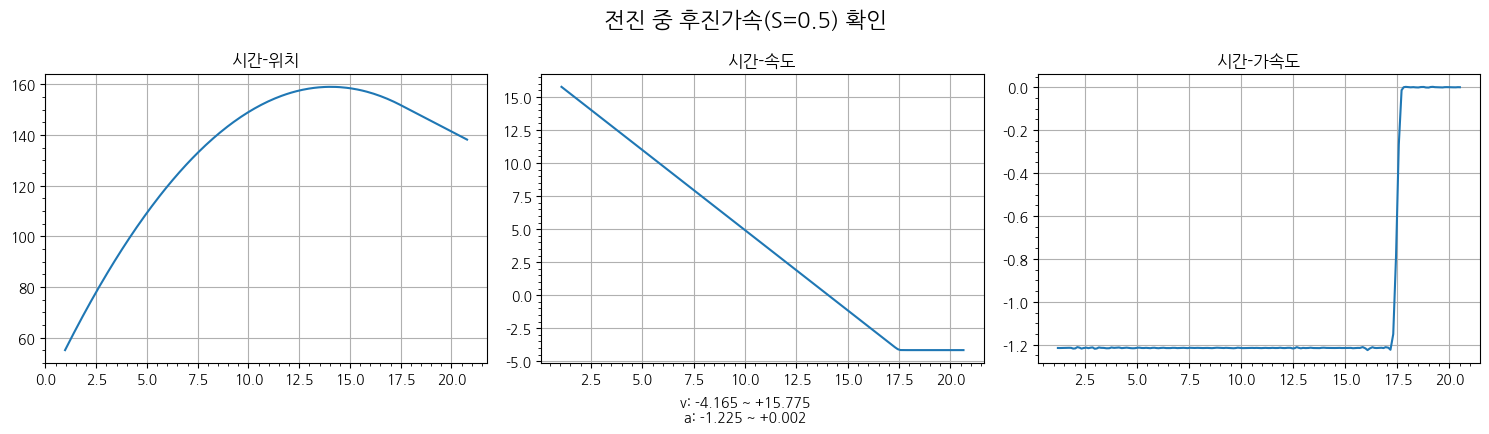

In [13]:
## WS

df = pd.read_csv('./check-physics.csv', header=None, names=['t', 'x', 'y', 'z', 'v', 'rx', 'ry', 'rz'])
# df = pd.read_csv(LOG_PATH, header=None, names=['t', 'x', 'y', 'z', 'v', 'rx', 'ry', 'rz'])
df = df.iloc[8:-1]

t = df["t"]
z = df["z"]
# v = df["v"]
v = np.gradient(z, t)  # 속도 계산
a = np.gradient(v, t)  # 가속도 계산
v = v[1:-1]  # 수치미분 오차 버려
a = a[2:-2]  # 수치미분 오차 버려

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].set_title('시간-위치')
axs[0].plot(t, z)
axs[1].set_title('시간-속도')
axs[1].plot(t[1:-1], v)
axs[2].set_title('시간-가속도')
a1 = 2.5
a2 = 2.4
# axs[2].plot(t[2:-2], np.maximum(np.minimum(a[0:], a1), a2))
axs[2].plot(t[2:-2], a)

for ax in axs:
    ax.grid(True)
    ax.minorticks_on()

fig.suptitle(f"전진 중 후진가속(S=0.5) 확인", fontsize=16)
fig.text(0.5, -0.05,
         f'v: {v.min():+.3f} ~ {v.max():+.3f}\na: {a.min():+.3f} ~ {a.max():+.3f}',
         ha='center')

plt.tight_layout()
plt.show()

In [237]:
# v.mean()
q = a[(a<a1) & (a>a2)]
q.mean()
# a.mean()

np.float64(2.431144701434099)

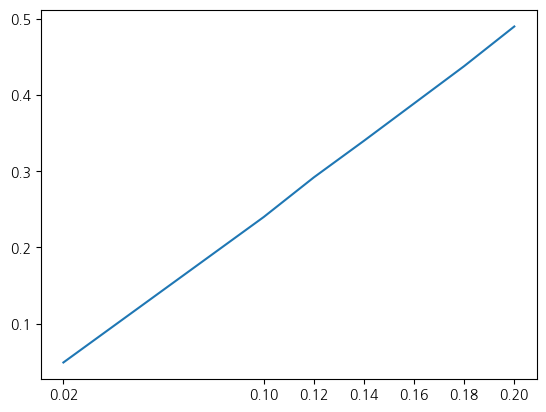

In [188]:
w      = [0.02,  0.10, 0.12,  0.14,  0.16,  0.18,  0.20,   0.5,  1.0,  2.0]
a_stop = [0.049, 0.24, 0.292, 0.340, 0.389, 0.438, 0.49,  1.21, 2.43, 4.86]

w = w[:-3]
a_stop = a_stop[:-3]

fig, ax = plt.subplots(1,1)
ax.plot(w, a_stop)
ax.set_xticks(w)

plt.show()